In [1]:
import os

import numpy as np
import pandas as pd
import pydicom
import zipfile
import matplotlib.pyplot as plt
import torch
from torch import cuda
import cupy as cp
import cupyx.scipy.ndimage
from typing import Union
from tqdm import tqdm
import seaborn as sns

In [3]:
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection.zip'
TRAIN_DATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_train'
METADATA_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/merged_metadata.csv'

dataset_handler = zipfile.ZipFile(DATASET_PATH)

In [4]:
sample_dcm_fname = f'{TRAIN_DATA_PATH}/ID_1534bee18.dcm'

In [5]:
with dataset_handler.open(sample_dcm_fname) as dcmf:
    ds = pydicom.dcmread(dcmf)
ds

/root/miniconda3/envs/capstone/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_1534bee18'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/root/miniconda3/envs/capstone/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_dcff5e7758'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/root/miniconda3/envs/capstone/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_13659d86f8'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 176
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 9999.135306150361854923264457486082433874260
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: ID_1534bee18
(0008,0060) Modality                            CS: 'CT'
(0010,0020) Patient ID                          LO: 'ID_6765d466'
(0020,000D) Study Instance UID                  UI: ID_dcff5e7758
(0020,000E) Series Instance UID                 UI: ID_13659d86f8
(0020,0010) Study ID                            SH: ''
(0020,0032) Image Posi

In [6]:
df = pd.read_csv(METADATA_PATH)
df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
0,ID_000012eaf,0,0,0,0,0,0,ID_f15c0eee,ID_30ea2b02d4,ID_0ab5820b2a,"['-125.000000', '-115.897980', '77.970825']",ID_000012eaf,77.970825
1,ID_000039fa0,0,0,0,0,0,0,ID_eeaf99e7,ID_134d398b61,ID_5f8484c3e0,"['-125.000000', '-141.318451', '62.720940']",ID_000039fa0,62.720940
2,ID_00005679d,0,0,0,0,0,0,ID_18f2d431,ID_b5c26cda09,ID_203cd6ec46,"['-134.463', '-110.785', '-39.569']",ID_00005679d,-39.569000
3,ID_00008ce3c,0,0,0,0,0,0,ID_ce8a3cd2,ID_974735bf79,ID_3780d48b28,"['-125', '-83.0468112', '175.995344']",ID_00008ce3c,175.995344
4,ID_0000950d7,0,0,0,0,0,0,ID_d278c67b,ID_8881b1c4b1,ID_84296c3845,"['-126.437378', '-126.437378', '157.500000']",ID_0000950d7,157.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0,ID_a85c9d08,ID_eca4bf46ac,ID_3ef9b97743,"['-152', '-56', '1011.99995']",ID_ffff82e46,1011.999950
752799,ID_ffff922b9,1,0,0,1,0,0,ID_5964c5e5,ID_b47ca0ad05,ID_6d2a9b2810,"['-126.408875', '-126.408875', '-235.611511']",ID_ffff922b9,-235.611511
752800,ID_ffffb670a,1,0,0,0,1,0,ID_4f7414e4,ID_ffb2e70ba3,ID_87b33b4a10,"['-125.000', '-133.686', '4.725']",ID_ffffb670a,4.725000
752801,ID_ffffcbff8,0,0,0,0,0,0,ID_a5382712,ID_ff0ba45814,ID_bd174db91c,"['-125.000', '-127.453', '35.433']",ID_ffffcbff8,35.433000


In [7]:
unique_series_uids = df['SeriesInstanceUID'].unique()
df_by_series_uids = {}
for k in tqdm(unique_series_uids, desc="Splitting df by SeriesInstanceUIDs"):
    df_by_series_uids[k] = df[df['SeriesInstanceUID'] == k]

Splitting df by SeriesInstanceUIDs: 100%|████████████████████████████████| 21744/21744 [16:47<00:00, 21.59it/s]


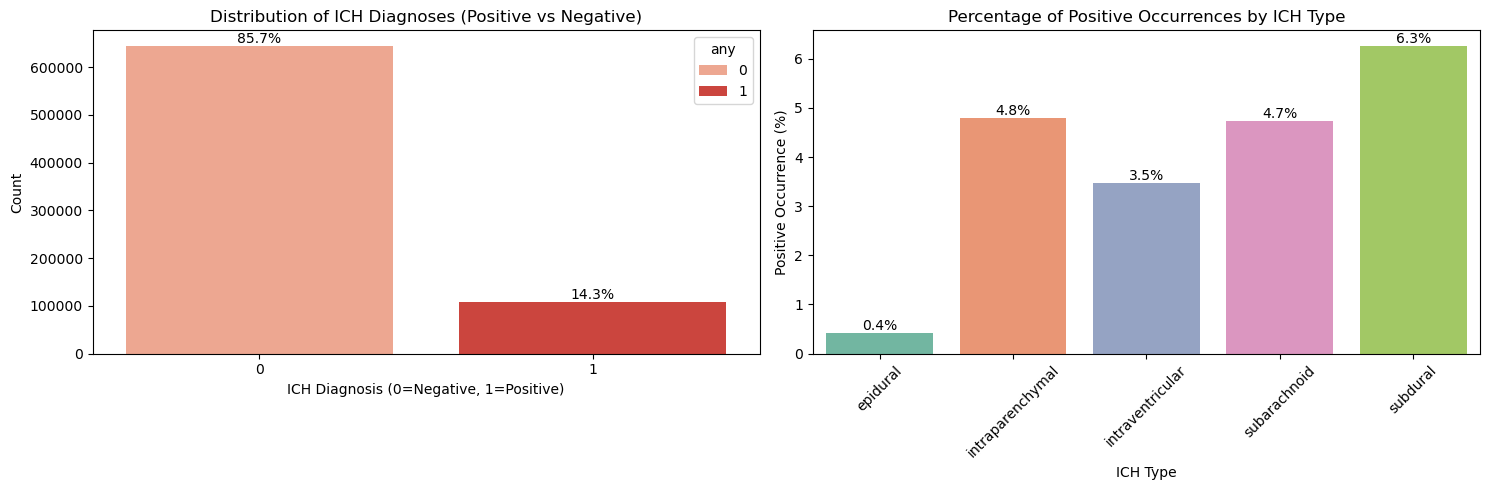

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df, x='any', hue='any',  ax=axes[0], palette='Reds')
axes[0].set_title("Distribution of ICH Diagnoses (Positive vs Negative)")
axes[0].set_xlabel("ICH Diagnosis (0=Negative, 1=Positive)")
axes[0].set_ylabel('Count')
for c in axes[0].containers:
    axes[0].bar_label(c , fmt=lambda x: f'{(x/df["any"].count())*100:0.1f}%')

melted_df = df.melt(id_vars=['Image'], value_vars=['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'], var_name='ICH Type', value_name='Diagnosis')

subtype_counts = melted_df.groupby('ICH Type')['Diagnosis'].value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / melted_df.groupby('ICH Type').size()*100
sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=axes[1], hue=subtype_counts.index, palette='Set2')
axes[1].set_title('Percentage of Positive Occurrences by ICH Type')
axes[1].set_xlabel('ICH Type')
axes[1].set_ylabel('Positive Occurrence (%)')
plt.setp(axes[1].get_xticklabels(), rotation=45)
for c in axes[1].containers:
    axes[1].bar_label(c ,fmt=lambda x: f'{x:0.01f}%')

plt.tight_layout()
plt.show()

In [41]:
print("BitsStored: ", ds.BitsStored)
print("PixelRepresentation: ", ds.PixelRepresentation)
print("RescaleSlope: ", ds.RescaleSlope)
print("ReslaceIntercept: ", int(ds.RescaleIntercept))

BitsStored:  16
PixelRepresentation:  1
RescaleSlope:  1
ReslaceIntercept:  -1024


In [9]:
def correct_dcm(dcm: pydicom.FileDataset):
    # x = torch.from_numpy(dcm.pixel_array).cuda()
    x = dcm.pixel_array
    x = x + 1000
    px_mode = 4096
    x[x >= px_mode] = x[x >= px_mode] - px_mode
    # dcm.PixelData = x.cpu().numpy().tobytes()
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    
def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    # Pixel to Hounsfield Unit (HU)
    # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
    img = dcm.pixel_array
    img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    
    return img

def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
    im = None
    match window:
        case 'brain':
            brain_img = window_image(dcm, 40, 80)
            brain_img = (brain_img - 0) / 80
            im = brain_img
        case 'subdural':
            subdural_img = window_image(dcm, 80, 200)
            subdural_img = (subdural_img - (-20)) / 200
            im = subdural_img
        case 'soft':
            soft_img = window_image(dcm, 40, 380)
            soft_img = (soft_img - (-150)) / 380
            im = soft_img
        case _:
            raise ValueError('invalid window argument')
    
    return im

In [10]:
series_iterator = iter(df_by_series_uids)

In [35]:
# df_unique_si = df[df['any'] == 1]
# df_unique_si = df[df['StudyInstanceUID'] == 'ID_ffb2e70ba3']
df_unique_si = df_by_series_uids[next(series_iterator)]
df_unique_si = df_unique_si.reset_index(drop=True)
df_unique_si = df_unique_si.sort_values(by='ImagePositionSpan', ascending=False).reset_index(drop=True)
df_unique_si

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,PatientID,StudyInstanceUID,SeriesInstanceUID,ImagePositionPatient,ImageId,ImagePositionSpan
0,ID_8b425cd24,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '247.5']",ID_8b425cd24,247.5
1,ID_0d7885b63,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '242.5']",ID_0d7885b63,242.5
2,ID_f6f777128,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '237.5']",ID_f6f777128,237.5
3,ID_b6a5e56f4,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '232.5']",ID_b6a5e56f4,232.5
4,ID_9717cfaa8,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '227.5']",ID_9717cfaa8,227.5
5,ID_dea913a5a,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '222.5']",ID_dea913a5a,222.5
6,ID_526703908,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '217.5']",ID_526703908,217.5
7,ID_a0f1da3ce,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '212.5']",ID_a0f1da3ce,212.5
8,ID_4c268e665,0,0,0,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '207.5']",ID_4c268e665,207.5
9,ID_20bc373af,1,0,1,0,0,0,ID_86541e96,ID_fbd067e39a,ID_3d2ee1643b,"['-125', '-5', '202.5']",ID_20bc373af,202.5


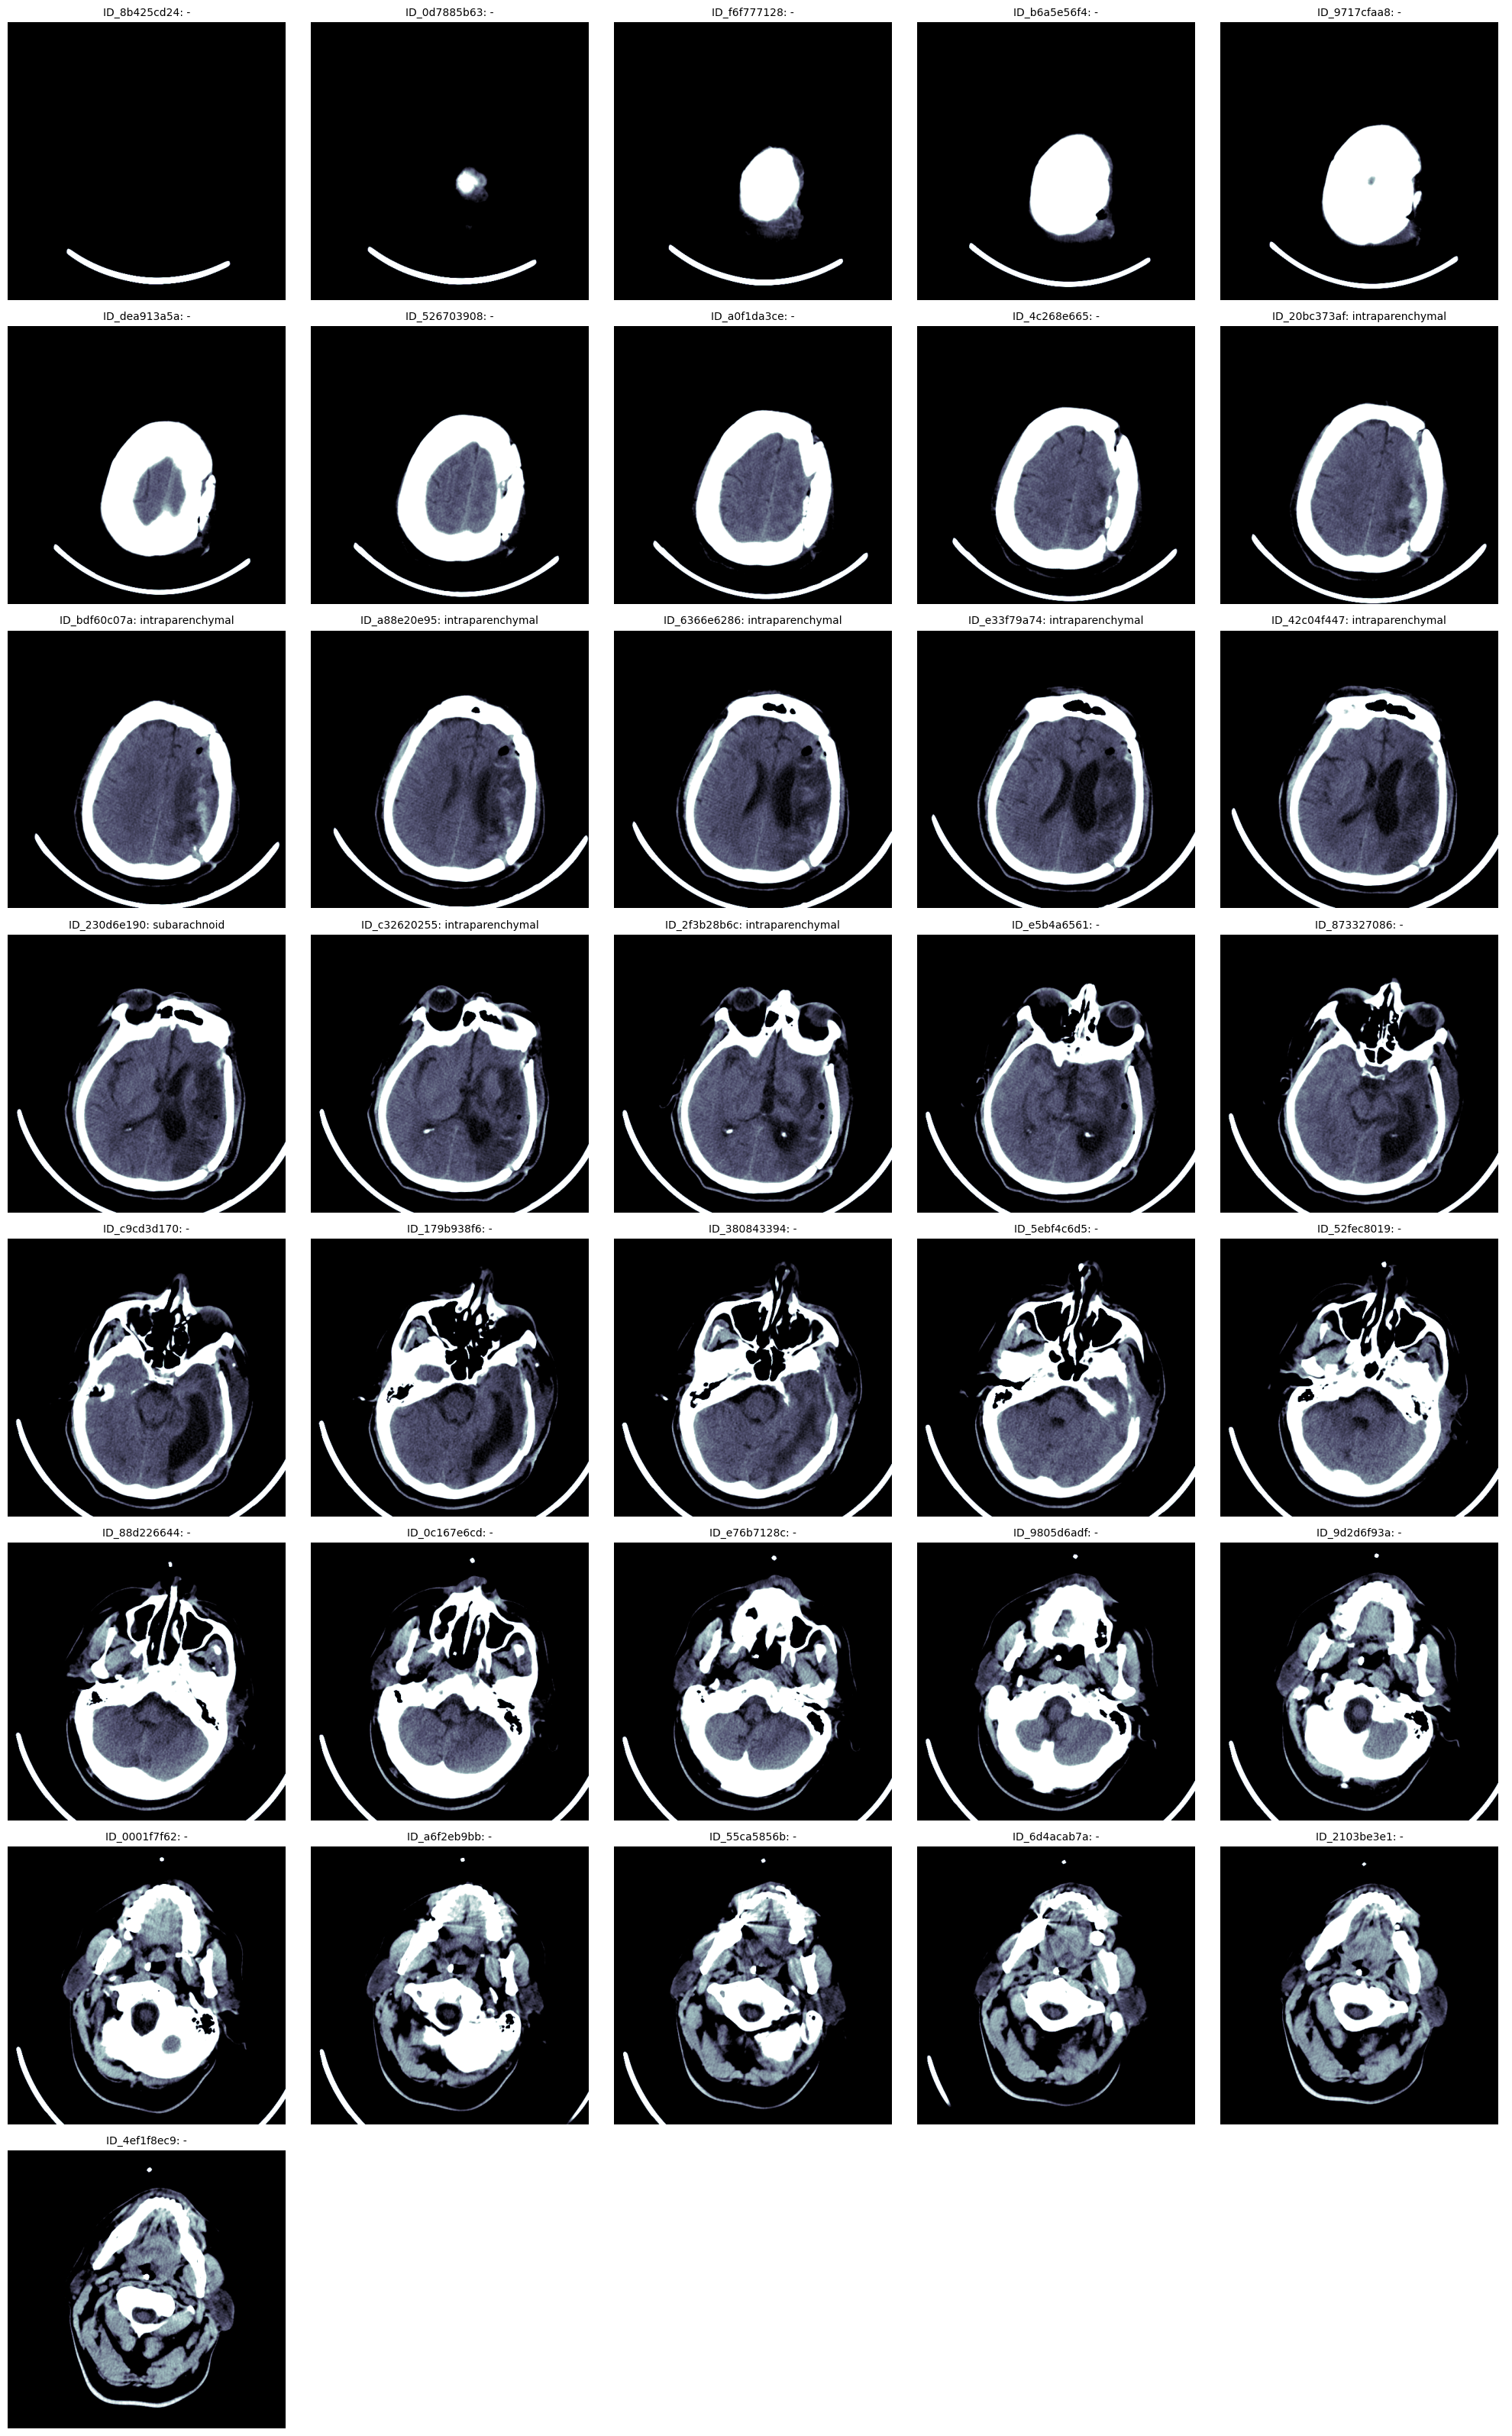

In [36]:
si_len = len(df_unique_si)
N, M = int(np.ceil(si_len/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))

for i, ax in enumerate(axes.flat):
    if i < si_len:
        im_fname = os.path.join(TRAIN_DATA_PATH, f"{df_unique_si.loc[i, 'Image']}.dcm")
        with dataset_handler.open(im_fname) as dcmf:
            _ds = pydicom.dcmread(dcmf)
            im = get_windowed_image(_ds, window='brain')
            true_diagnosis = df_unique_si.iloc[i,2:7]
            true_diagnosis = true_diagnosis[true_diagnosis == 1].index.tolist()
            true_diagnosis = ', '.join(true_diagnosis) if len(true_diagnosis) > 0 else '-'
            ax.imshow(im, cmap=plt.cm.bone)
            ax.axis('off')
            ax.set_title(f"{df_unique_si.loc[i, 'Image']}: {true_diagnosis}")
            ax.title.set_size(10)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()